In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [111]:
def dicky_fuller(df):
    i = 0
    dftest = adfuller(np.diff(df,i), autolag='AIC')
    test_stat = dftest[0]
    critical_val_5 = dftest[4]['5%']
    while test_stat > critical_val_5:
        i+=1
        dftest = adfuller(np.diff(df,i), autolag='AIC')
        test_stat = dftest[0]
        critical_val_5 = dftest[4]['5%']
    return(i)

In [112]:
df_lf = pd.read_csv('../../src/data/df_lf_arima.csv', index_col='time', parse_dates=['time'])
# df_lf.head()

In [119]:
zipcodes = [37115, 37148, 37221, 37174, 37210]

shape of train and test datasets: (61,) (15,) 



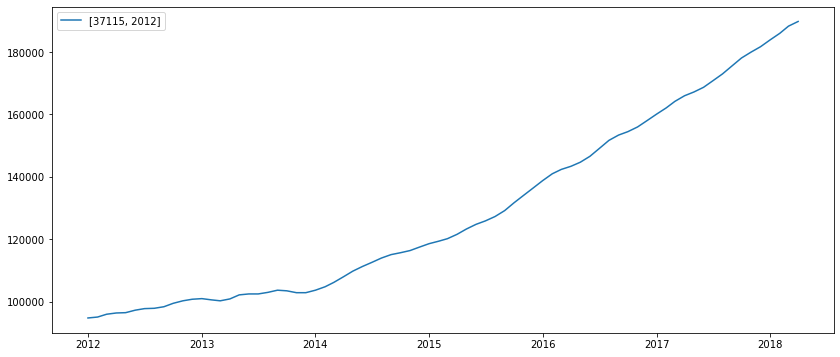

In [209]:
zip_code = zipcodes[0]    # change these params
start_year = 2012   # change these params (1996, 2010 or 2012)
eoti_percent = .8

df_zip_code = df_lf[(df_lf.RegionName== zip_code) & (df_lf.index.year >= start_year)]

eoti = round(df_zip_code.shape[0] * eoti_percent)
df_zip_code_train = df_zip_code.value[:eoti]
df_zip_code_test = df_zip_code.value[eoti:]

print("shape of train and test datasets:", df_zip_code_train.shape, df_zip_code_test.shape, '\n')

plt.subplots(figsize = (14,6))
plt.plot(df_zip_code.value, label=[zip_code,start_year])
plt.legend(loc='best');

# ARIMA

## d

In [204]:
dicky_fuller(df_zip_code_train)

# order of differencing

2

## p, q

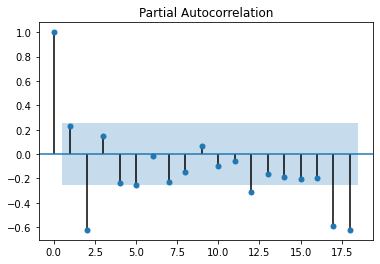

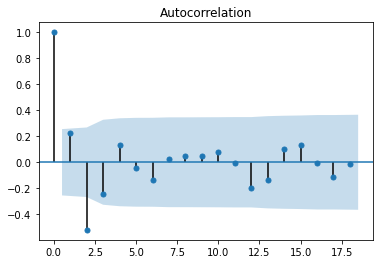

In [210]:
i = dicky_fuller(df_zip_code_train)

plot_pacf(np.diff(df_zip_code_train,i)); #ar

plot_acf(np.diff(df_zip_code_train,i)); #ma

# looks like 0,2,0 are the best params, at i = 2, 
# but they won't work with ARIMA.

In [208]:
# Let's check auto_arima for suggestions, shall we:

auto_arima(df_zip_code_train, start_p=0, d=i, start_q=0, max_p=5, max_q=5, seasonal=False, trace=True)

# Auto_arima agrees, 0,2,0 is the best. since can't do that, will choose 0,2,1

# NOTE: from the SARIMA model below, 2,2,2 gave better aic. Got better results with ARIMA too.
# But auto_arima didn't even check for it here...

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=854.374, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=855.192, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=855.249, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=852.380, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=856.775, Time=0.10 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.226 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, with_intercept=False)

## Modeling (ARIMA)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -424.662
Method:                       css-mle   S.D. of innovations            313.723
Date:                Thu, 12 Nov 2020   AIC                            861.324
Time:                        13:16:49   BIC                            873.789
Sample:                    03-01-2012   HQIC                           866.189
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             39.4201     59.173      0.666      0.505     -76.557     155.397
ar.L1.D2.value    -0.3257      0.147     -2.210      0.027      -0.615      -0.037
ar.L2.D2.value    -0.7361      0.100

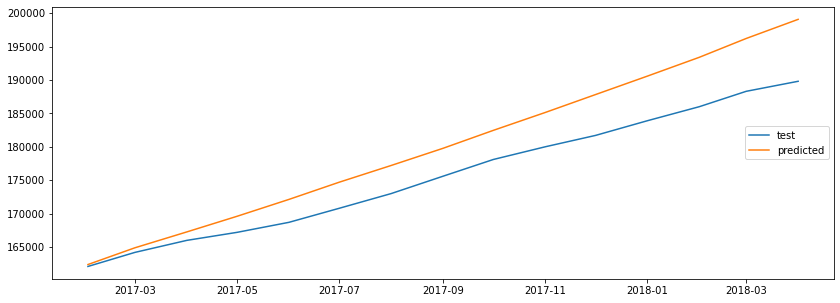

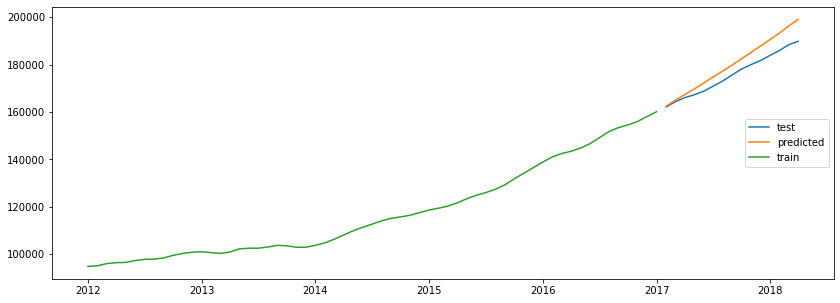

In [124]:
ar, i, ma = [2,2,2] # change these params

model = ARIMA(df_zip_code_train, (ar,i,ma), freq='MS').fit()
y_hat_model = model.predict(typ='levels')
rmse_model = np.sqrt(mean_squared_error(df_zip_code_train[i:], y_hat_model))

test_start_dt = df_zip_code_test.index[0]
test_end_dt = df_zip_code_test.index[-1]
y_hat_model_test = model.predict(start=test_start_dt, end=test_end_dt, typ='levels')
rmse_model_test = np.sqrt(mean_squared_error(df_zip_code_test, y_hat_model_test))

print(model.summary(), '\n')
print('train rmse:', rmse_model, '\n')
print('test rmse:', rmse_model_test, '\n')
print('train aic:', model.aic, '\n')

fig, ax2 = plt.subplots(figsize=(14,5))
ax2.plot(df_zip_code_test, label='test')
ax2.plot(y_hat_model_test, label='predicted')
ax2.legend(loc="right")

fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(df_zip_code_test, label='test')
ax1.plot(y_hat_model_test, label='predicted')
ax1.plot(df_zip_code_train, label='train')
ax1.legend(loc="right");

# SARIMAX

In [125]:
import itertools

i = dicky_fuller(df_zip_code_train)

p = q = range(0, 3)
pdq = list(itertools.product(p, [i], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 2, 0) x (0, 1, 0, 12)
SARIMAX: (0, 2, 0) x (0, 1, 1, 12)
SARIMAX: (0, 2, 0) x (0, 1, 2, 12)
SARIMAX: (0, 2, 0) x (1, 1, 0, 12)
SARIMAX: (0, 2, 0) x (1, 1, 1, 12)
SARIMAX: (0, 2, 0) x (1, 1, 2, 12)
SARIMAX: (0, 2, 0) x (2, 1, 0, 12)
SARIMAX: (0, 2, 0) x (2, 1, 1, 12)
SARIMAX: (0, 2, 0) x (2, 1, 2, 12)
SARIMAX: (0, 2, 1) x (0, 1, 0, 12)
SARIMAX: (0, 2, 1) x (0, 1, 1, 12)
SARIMAX: (0, 2, 1) x (0, 1, 2, 12)
SARIMAX: (0, 2, 1) x (1, 1, 0, 12)
SARIMAX: (0, 2, 1) x (1, 1, 1, 12)
SARIMAX: (0, 2, 1) x (1, 1, 2, 12)
SARIMAX: (0, 2, 1) x (2, 1, 0, 12)
SARIMAX: (0, 2, 1) x (2, 1, 1, 12)
SARIMAX: (0, 2, 1) x (2, 1, 2, 12)
SARIMAX: (0, 2, 2) x (0, 1, 0, 12)
SARIMAX: (0, 2, 2) x (0, 1, 1, 12)
SARIMAX: (0, 2, 2) x (0, 1, 2, 12)
SARIMAX: (0, 2, 2) x (1, 1, 0, 12)
SARIMAX: (0, 2, 2) x (1, 1, 1, 12)
SARIMAX: (0, 2, 2) x (1, 1, 2, 12)
SARIMAX: (0, 2, 2) x (2, 1, 0, 12)
SARIMAX: (0, 2, 2) x (2, 1, 1, 12)
SARIMAX: (0, 2, 2) x (2, 1, 2, 12)
SARIMAX: (1, 2, 0) 

In [126]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(df_zip_code_train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False, 
                         freq='MS')
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:739.507127257072


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:921.5640974953036
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:348.5377340585172
ARIMA(0, 2, 0)x(1, 1, 0, 12) - AIC:538.1015920183934


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(1, 1, 1, 12) - AIC:1574.995979790494
ARIMA(0, 2, 0)x(1, 1, 2, 12) - AIC:347.1913111955339
ARIMA(0, 2, 0)x(2, 1, 0, 12) - AIC:359.71708511187205


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(2, 1, 1, 12) - AIC:604.1074280396389


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(2, 1, 2, 12) - AIC:349.04431705054054
ARIMA(0, 2, 1)x(0, 1, 0, 12) - AIC:707.0846958853389


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(0, 1, 1, 12) - AIC:523.4583313396505
ARIMA(0, 2, 1)x(0, 1, 2, 12) - AIC:324.30090870138895
ARIMA(0, 2, 1)x(1, 1, 0, 12) - AIC:539.7958617012677


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(1, 1, 1, 12) - AIC:1162.9212110702067
ARIMA(0, 2, 1)x(1, 1, 2, 12) - AIC:325.06968966207324


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(2, 1, 0, 12) - AIC:361.7105022887313


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(2, 1, 1, 12) - AIC:575.2383177183277
ARIMA(0, 2, 1)x(2, 1, 2, 12) - AIC:329.22271246909776
ARIMA(0, 2, 2)x(0, 1, 0, 12) - AIC:680.3676100851715


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(0, 1, 1, 12) - AIC:2018.9644419026026


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(0, 1, 2, 12) - AIC:301.24129351440416


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 0, 12) - AIC:539.4428566274089


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 1, 12) - AIC:nan


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 2, 12) - AIC:307.4100710773852
ARIMA(0, 2, 2)x(2, 1, 0, 12) - AIC:358.4828267791329


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(2, 1, 1, 12) - AIC:nan


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(2, 1, 2, 12) - AIC:311.74387990944433
ARIMA(1, 2, 0)x(0, 1, 0, 12) - AIC:738.8577429258805


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(0, 1, 1, 12) - AIC:838.4444439089245
ARIMA(1, 2, 0)x(0, 1, 2, 12) - AIC:346.0959172589715
ARIMA(1, 2, 0)x(1, 1, 0, 12) - AIC:520.1690870527591


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(1, 1, 1, 12) - AIC:1661.799406916834
ARIMA(1, 2, 0)x(1, 1, 2, 12) - AIC:345.0793670559997


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 0, 12) - AIC:342.9475688595281


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 1, 12) - AIC:988.2906255885656


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 2, 12) - AIC:347.11973889454936
ARIMA(1, 2, 1)x(0, 1, 0, 12) - AIC:709.1538483819398


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(0, 1, 1, 12) - AIC:1235.6650634964042
ARIMA(1, 2, 1)x(0, 1, 2, 12) - AIC:326.2768482625869
ARIMA(1, 2, 1)x(1, 1, 0, 12) - AIC:521.524833041476


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(1, 1, 1, 12) - AIC:1413.3268816101788
ARIMA(1, 2, 1)x(1, 1, 2, 12) - AIC:326.26039486235413


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 0, 12) - AIC:342.942326405817


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 1, 12) - AIC:708.0317725452902


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 2, 12) - AIC:330.9271884443519
ARIMA(1, 2, 2)x(0, 1, 0, 12) - AIC:683.0841471651444


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(0, 1, 1, 12) - AIC:1244.0845346823585
ARIMA(1, 2, 2)x(0, 1, 2, 12) - AIC:310.75206935993884


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:521.2969434628892


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:1063.8766274902962
ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:312.3099409110797


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 0, 12) - AIC:341.44553765405743


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 1, 12) - AIC:1011.1954754258315
ARIMA(1, 2, 2)x(2, 1, 2, 12) - AIC:312.63227532815944
ARIMA(2, 2, 0)x(0, 1, 0, 12) - AIC:696.8318080430075


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(0, 1, 1, 12) - AIC:671.7765448371955
ARIMA(2, 2, 0)x(0, 1, 2, 12) - AIC:333.9753643834554


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(1, 1, 0, 12) - AIC:490.35052113818693


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(1, 1, 1, 12) - AIC:963.0383463693454
ARIMA(2, 2, 0)x(1, 1, 2, 12) - AIC:334.9071467192183


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(2, 1, 0, 12) - AIC:313.4529344695118


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(2, 1, 1, 12) - AIC:443.47015234790257
ARIMA(2, 2, 0)x(2, 1, 2, 12) - AIC:317.35704791510966
ARIMA(2, 2, 1)x(0, 1, 0, 12) - AIC:698.5269874194867


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(0, 1, 1, 12) - AIC:1587.43583994057
ARIMA(2, 2, 1)x(0, 1, 2, 12) - AIC:319.7423359914868


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 0, 12) - AIC:492.0538788068469


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 1, 12) - AIC:1649.2275201537475
ARIMA(2, 2, 1)x(1, 1, 2, 12) - AIC:320.56006111987216


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(2, 1, 0, 12) - AIC:315.17596359897686


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(2, 1, 1, 12) - AIC:910.8085748432043
ARIMA(2, 2, 1)x(2, 1, 2, 12) - AIC:322.5482304581907
ARIMA(2, 2, 2)x(0, 1, 0, 12) - AIC:674.5812861041143


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(0, 1, 1, 12) - AIC:1586.1973093281947


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(0, 1, 2, 12) - AIC:300.98116449958405
ARIMA(2, 2, 2)x(1, 1, 0, 12) - AIC:493.0033525209441


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 1, 12) - AIC:1573.4317684201537


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 2, 12) - AIC:305.2459447596299
ARIMA(2, 2, 2)x(2, 1, 0, 12) - AIC:317.17130228202575


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(2, 1, 1, 12) - AIC:501.96376651614804
ARIMA(2, 2, 2)x(2, 1, 2, 12) - AIC:304.9152275566815


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                   61
Model:             SARIMAX(2, 2, 2)x(0, 1, 2, 12)   Log Likelihood                -143.491
Date:                            Thu, 12 Nov 2020   AIC                            300.981
Time:                                    13:19:59   BIC                            307.951
Sample:                                01-01-2012   HQIC                           302.342
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1149      0.415     -0.277      0.782      -0.929       0.699
ar.L2         -0.4370      0.371   

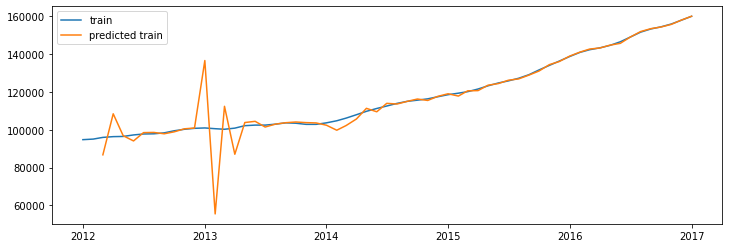

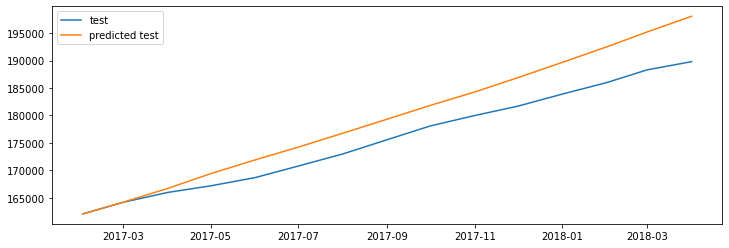

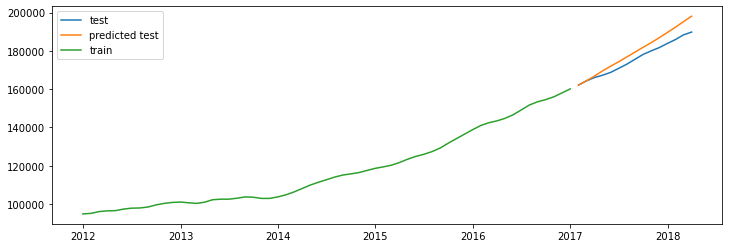

In [127]:
# ARIMA(2, 2, 2)x(0, 1, 2, 12) - AIC:300.98116449958405

p,d,q = [2,2,2]
P,D,Q,s = [0,1,2,12]

sari_mod =SARIMAX(df_zip_code_train,order=(p,d,q),
                  seasonal_order=(P,D,Q,s),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
                  freq='MS').fit()

y_hat_train = sari_mod.predict(typ='levels')
# second order differencing results in the first 2 predictions of a SARIMAX being invalid basically.
# in order to address that, subset from the 3rd prediction/value onwards.
# hence the [d:] below when calculating sarimax rmse train
rmse_sarimax_train = np.sqrt(mean_squared_error(df_zip_code_train[d:], y_hat_train[d:]))

y_hat_test = sari_mod.predict(start=df_zip_code_test.index[0], end=df_zip_code_test.index[-1],typ='levels')
rmse_sarimax_test = np.sqrt(mean_squared_error(df_zip_code_test,y_hat_test))

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(df_zip_code_train, label='train')
ax1.plot(y_hat_train[d:], label='predicted train')
ax1.legend(loc='best');

fig, ax2 = plt.subplots(figsize=(12,4))
ax2.plot(df_zip_code_test, label='test')
ax2.plot(y_hat_test, label='predicted test')
ax2.legend(loc='best')

fig, ax3 = plt.subplots(figsize=(12,4))
ax3.plot(df_zip_code_test, label='test')
ax3.plot(y_hat_test, label='predicted test')
ax3.plot(df_zip_code_train, label='train')
ax3.legend(loc='best')

print(sari_mod.summary(), '\n')

print('(ARIMA) train RMSE:   ', rmse_model,)
print('(SARIMAX) train RMSE: ', rmse_sarimax_train,'\n')

print('(ARIMA) test RMSE:   ', rmse_model_test)
print('(SARIMAX) test RMSE: ', rmse_sarimax_test,'\n')

print('(ARIMA) train AIC:   ', model.aic)
print('(SARIMAX) train AIC: ', sari_mod.aic, '\n')

# Forecast

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


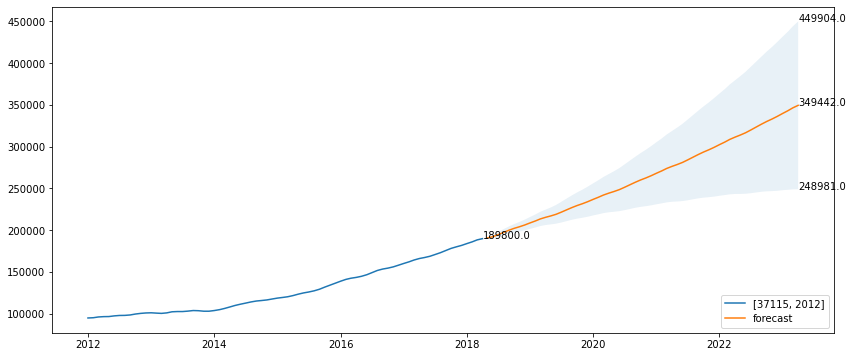

In [202]:
n = 60

sari_mod =SARIMAX(df_zip_code.value, order=(p,d,q),
                  seasonal_order=(P,D,Q,s),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
                  freq='MS').fit()

forecast = sari_mod.forecast(steps = n)

get_forecast = sari_mod.get_forecast(steps=n).summary_frame()

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df_zip_code.value, label=[zip_code,start_year])
ax.plot(forecast, label='forecast')
ax.fill_between(get_forecast.index, get_forecast.mean_ci_lower, get_forecast.mean_ci_upper, alpha=0.1)

ax.annotate(round(df_zip_code.value[-1],0),
            (df_zip_code.index[-1], df_zip_code.value[-1]))
ax.annotate(round(get_forecast.mean_ci_upper[-1],0),
            (get_forecast.index[-1], get_forecast.mean_ci_upper[-1]))
ax.annotate(round(get_forecast['mean'][-1],0),
            (get_forecast.index[-1], get_forecast['mean'][-1]))
ax.annotate(round(get_forecast.mean_ci_lower[-1],0),
            (get_forecast.index[-1], get_forecast.mean_ci_lower[-1]))

ax.legend(loc='lower right');

In [134]:
b = df_zip_code.value[-1]
b

189800.0

In [135]:
e = forecast.values[-1]
e

349442.216535368

In [136]:
percent_diff_37115 = (e-b)/b
print('difference in percentage: ', percent_diff_37115*100)

difference in percentage:  84.11075686794942


# Conclusion: ARIMA vs Prophet (hunters model)

We're choosing Hunters model bc it has a lower RMSE, & MAPE (calculated below), for our test vs predicted data.

In [138]:
df_zip_code_test

time
2017-02-01    162100.0
2017-03-01    164200.0
2017-04-01    166000.0
2017-05-01    167200.0
2017-06-01    168700.0
2017-07-01    170800.0
2017-08-01    173000.0
2017-09-01    175600.0
2017-10-01    178100.0
2017-11-01    180000.0
2017-12-01    181700.0
2018-01-01    183900.0
2018-02-01    186000.0
2018-03-01    188300.0
2018-04-01    189800.0
Name: value, dtype: float64

In [137]:
y_hat_test

2017-02-01    162093.369182
2017-03-01    164226.805791
2017-04-01    166721.424526
2017-05-01    169416.146019
2017-06-01    171919.269202
2017-07-01    174241.309504
2017-08-01    176771.358794
2017-09-01    179334.631723
2017-10-01    181837.234763
2017-11-01    184284.124348
2017-12-01    186884.032244
2018-01-01    189673.184642
2018-02-01    192499.456913
2018-03-01    195194.912393
2018-04-01    198059.160606
Freq: MS, dtype: float64

In [130]:
MAPE = round(np.mean(np.abs(df_zip_code_test - y_hat_test)/ df_zip_code_test) * 100, 2) #mean absolute percentage error
MAPE

2.13

In [97]:
zip_code

37115